In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sunilthite/text-document-classification-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/text-document-classification-dataset


# Import des biblios nécessaires

In [31]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import torch
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification, Trainer, TrainingArguments,AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import string
from torch.optim import AdamW
from transformers import AutoTokenizer
from torch.utils.data import Dataset, DataLoader
from transformers import get_scheduler
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset
import torch
from sklearn.metrics import accuracy_score
from tqdm import tqdm
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [37]:

file_path = "/kaggle/input/text-document-classification-dataset/df_file.csv"

df = pd.read_csv(file_path)

print(df.columns)

Index(['Text', 'Label'], dtype='object')


Dataset contains 2 columns Text and label

In [38]:
print(df.head(5))

                                                Text  Label
0  Budget to set scene for election\n \n Gordon B...      0
1  Army chiefs in regiments decision\n \n Militar...      0
2  Howard denies split over ID cards\n \n Michael...      0
3  Observers to monitor UK election\n \n Minister...      0
4  Kilroy names election seat target\n \n Ex-chat...      0


Label is a numeric field

In [39]:
label_counts = df["Label"].value_counts()

print(label_counts)

Label
1    511
4    510
0    417
2    401
3    386
Name: count, dtype: int64


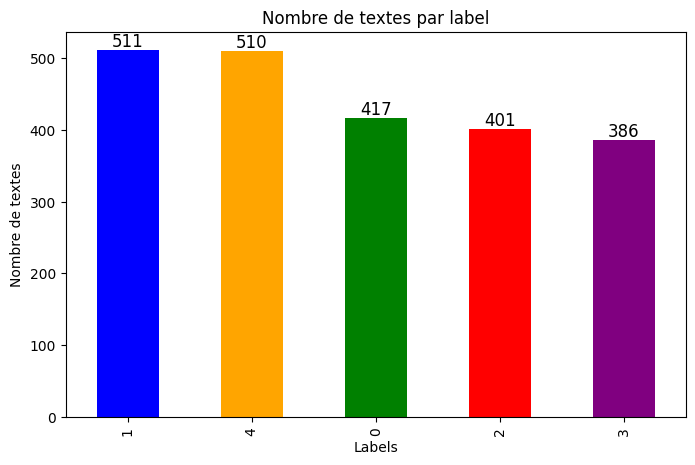

In [40]:
plt.figure(figsize=(8,5))
label_counts.plot(kind='bar', color=['blue', 'orange', 'green', 'red', 'purple'])

plt.title("Nombre de textes par label")
plt.xlabel("Labels")
plt.ylabel("Nombre de textes")

for i, v in enumerate(label_counts):
    plt.text(i, v + 5, str(v), ha='center', fontsize=12)

plt.show()

In [41]:
stop_words = set(stopwords.words('english'))

In [42]:
def cleanText(text):
    if isinstance(text,float):
        return " "
    else:
        text=text.lower()
        text=re.sub(r"[^\w\s]"," ",text) #Supprimer la ponctuation
        text=re.sub(r"\d+[A-Za-z]*\d+"," ",text).strip()  #Eliminer les chiffres
        text=re.sub(r"\s+"," ",text).strip()  #Supprimer les espaces multiples
        words = word_tokenize(text)  # Tokenisation
        words = [word for word in words if word not in stop_words] 
        return " ".join(words)

In [43]:
df["Cleaned_Text"] = df["Text"].apply(cleanText)

print(df[["Text", "Cleaned_Text","Label"]].head())

                                                Text  \
0  Budget to set scene for election\n \n Gordon B...   
1  Army chiefs in regiments decision\n \n Militar...   
2  Howard denies split over ID cards\n \n Michael...   
3  Observers to monitor UK election\n \n Minister...   
4  Kilroy names election seat target\n \n Ex-chat...   

                                        Cleaned_Text  Label  
0  budget set scene election gordon brown seek pu...      0  
1  army chiefs regiments decision military chiefs...      0  
2  howard denies split id cards michael howard de...      0  
3  observers monitor uk election ministers invite...      0  
4  kilroy names election seat target ex chat show...      0  


In [44]:
cleaned_df = df[["Cleaned_Text", "Label"]]

cleaned_df.to_csv("/kaggle/working/cleaned_text_labels.csv", index=False)

print("Le fichier a été sauvegardé sous : /kaggle/working/cleaned_text_labels.csv")

Le fichier a été sauvegardé sous : /kaggle/working/cleaned_text_labels.csv


In [30]:

file_path = "/kaggle/working/cleaned_text_labels.csv"

data = pd.read_csv(file_path)

print(data.columns)

Index(['Cleaned_Text', 'Label'], dtype='object')


In [32]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    data['Cleaned_Text'], data['Label'], test_size=0.2, random_state=42)

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

train_encodings = tokenizer(train_texts.tolist(), padding=True, truncation=True, return_tensors="pt")
val_encodings = tokenizer(val_texts.tolist(), padding=True, truncation=True, return_tensors="pt")

train_labels = torch.tensor(train_labels.tolist())
val_labels = torch.tensor(val_labels.tolist())

train_data = TensorDataset(train_encodings.input_ids, train_labels)
val_data = TensorDataset(val_encodings.input_ids, val_labels)

train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
val_loader = DataLoader(val_data, batch_size=8)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [34]:
# Charger le modèle BERT pour la classification
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=5)  # Ajustez num_labels si vous avez plus de classes

# Optimizer et Scheduler
optimizer = AdamW(model.parameters(), lr=5e-5)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [46]:
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Training epoch {epoch + 1}"):
        batch_input_ids, batch_labels = [x.to(device) for x in batch]
        
        optimizer.zero_grad()
        outputs = model(input_ids=batch_input_ids, labels=batch_labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {total_loss / len(train_loader)}")
    
    # Évaluation sur le jeu de validation
    model.eval()
    total_eval_accuracy = 0
    for batch in val_loader:
        batch_input_ids, batch_labels = [x.to(device) for x in batch]
        
        with torch.no_grad():
            outputs = model(input_ids=batch_input_ids)
        
        predictions = torch.argmax(outputs.logits, dim=-1)
        accuracy = (predictions == batch_labels).sum().item()
        total_eval_accuracy += accuracy

    eval_accuracy = total_eval_accuracy / len(val_loader.dataset)
    print(f"Validation Accuracy: {eval_accuracy:.4f}")

Training epoch 1: 100%|██████████| 223/223 [01:36<00:00,  2.31it/s]


Epoch 1/20, Training Loss: 1.078163422276621
Validation Accuracy: 0.8966


Training epoch 2: 100%|██████████| 223/223 [01:36<00:00,  2.31it/s]


Epoch 2/20, Training Loss: 0.15788792320548017
Validation Accuracy: 0.9596


Training epoch 3: 100%|██████████| 223/223 [01:36<00:00,  2.31it/s]


Epoch 3/20, Training Loss: 0.07796467711413989
Validation Accuracy: 0.9506


Training epoch 4: 100%|██████████| 223/223 [01:36<00:00,  2.31it/s]


Epoch 4/20, Training Loss: 0.06637651563283774
Validation Accuracy: 0.9640


Training epoch 5: 100%|██████████| 223/223 [01:36<00:00,  2.31it/s]


Epoch 5/20, Training Loss: 0.05216022519887563
Validation Accuracy: 0.9618


Training epoch 6: 100%|██████████| 223/223 [01:36<00:00,  2.31it/s]


Epoch 6/20, Training Loss: 0.04240689225152402
Validation Accuracy: 0.9663


Training epoch 7: 100%|██████████| 223/223 [01:36<00:00,  2.31it/s]


Epoch 7/20, Training Loss: 0.0604602543505602
Validation Accuracy: 0.9730


Training epoch 8: 100%|██████████| 223/223 [01:36<00:00,  2.31it/s]


Epoch 8/20, Training Loss: 0.030818802228347802
Validation Accuracy: 0.9685


Training epoch 9: 100%|██████████| 223/223 [01:36<00:00,  2.31it/s]


Epoch 9/20, Training Loss: 0.006931956214287356
Validation Accuracy: 0.9775


Training epoch 10: 100%|██████████| 223/223 [01:36<00:00,  2.31it/s]


Epoch 10/20, Training Loss: 0.004991482223400788
Validation Accuracy: 0.9775


Training epoch 11: 100%|██████████| 223/223 [01:36<00:00,  2.31it/s]


Epoch 11/20, Training Loss: 0.003833043089631377
Validation Accuracy: 0.9775


Training epoch 12: 100%|██████████| 223/223 [01:36<00:00,  2.31it/s]


Epoch 12/20, Training Loss: 0.005229946731740083
Validation Accuracy: 0.9753


Training epoch 13: 100%|██████████| 223/223 [01:36<00:00,  2.31it/s]


Epoch 13/20, Training Loss: 0.0042723743995440695
Validation Accuracy: 0.9753


Training epoch 14: 100%|██████████| 223/223 [01:36<00:00,  2.31it/s]


Epoch 14/20, Training Loss: 0.0038047492495767205
Validation Accuracy: 0.9775


Training epoch 15: 100%|██████████| 223/223 [01:36<00:00,  2.31it/s]


Epoch 15/20, Training Loss: 0.003985795222176866
Validation Accuracy: 0.9775


Training epoch 16: 100%|██████████| 223/223 [01:36<00:00,  2.31it/s]


Epoch 16/20, Training Loss: 0.005038133546612915
Validation Accuracy: 0.9775


Training epoch 17: 100%|██████████| 223/223 [01:36<00:00,  2.31it/s]


Epoch 17/20, Training Loss: 0.004908048897572363
Validation Accuracy: 0.9708


Training epoch 18: 100%|██████████| 223/223 [01:36<00:00,  2.31it/s]


Epoch 18/20, Training Loss: 0.004349538302526709
Validation Accuracy: 0.9775


Training epoch 19: 100%|██████████| 223/223 [01:36<00:00,  2.31it/s]


Epoch 19/20, Training Loss: 0.003934940366693585
Validation Accuracy: 0.9798


Training epoch 20: 100%|██████████| 223/223 [01:36<00:00,  2.31it/s]


Epoch 20/20, Training Loss: 0.003708800581553241
Validation Accuracy: 0.9798


In [49]:
# S'assurer que le modèle est en mode évaluation
model.eval()

# Variables pour l'accuracy
total_eval_accuracy = 0
total_eval_loss = 0

# Désactivation de la rétropropagation pour éviter les calculs inutiles
with torch.no_grad():
    # Parcours des données de validation
    for batch in tqdm(val_loader, desc="Evaluating"):
        batch_input_ids, batch_labels = [x.to(device) for x in batch]
        
        # Passer le batch à travers le modèle
        outputs = model(input_ids=batch_input_ids, labels=batch_labels)
        
        # Calcul de la perte
        loss = outputs.loss
        total_eval_loss += loss.item()
        
        # Calcul des prédictions et de l'accuracy
        predictions = torch.argmax(outputs.logits, dim=-1)
        accuracy = (predictions == batch_labels).sum().item()
        total_eval_accuracy += accuracy

# Calcul de l'accuracy générale sur l'ensemble de validation
eval_accuracy = total_eval_accuracy / len(val_loader.dataset)
eval_loss = total_eval_loss / len(val_loader)

# Affichage des résultats
print(f"Validation Loss: {eval_loss:.4f}")
print(f"Validation Accuracy: {eval_accuracy:.4f}")

Evaluating: 100%|██████████| 56/56 [00:06<00:00,  8.64it/s]

Validation Loss: 0.1920
Validation Accuracy: 0.9798


In [ ]:
example_index = 240  # Vous pouvez changer cet index pour tester un autre exemple
example_text = val_texts.iloc[example_index]  # Récupérer un texte du dataset de validation


# Tokenization du texte
inputs = tokenizer(example_text, return_tensors='pt', padding=True, truncation=True, max_length=512)

# Assurez-vous que l'entrée est sur le même appareil que le modèle (GPU ou CPU)
inputs = {key: value.to(device) for key, value in inputs.items()}

# Modèle en mode évaluation
model.eval()

# Désactivation de la rétropropagation
with torch.no_grad():
    # Passage du texte à travers le modèle
    outputs = model(**inputs)

# Prédiction de la classe
predicted_class = torch.argmax(outputs.logits, dim=-1).item()

# Classe réelle
true_class = val_labels[example_index].item()

# Affichage des résultats
print(f"Texte : {example_text}")
print(f"Classe réelle : {true_class}")
print(f"Classe prédite : {predicted_class}")
